# 영상의 이진화

## 이진화 (Binarization)
* 영상에서 관심 영역(ROI, Region Of Interest)과 그렇지 않은 비관심 영역으로 구분하는 것
* **cv2.threshold(src, thresh, maxVal, type)** : 임계값을 이용한 다양한 연산 지원 함수
    * maxVal : 이진화 적용 후 결과 영상의 최대 값 (보통 255)
    * type : 임계값 연산 방법 (ex. THRESH_BINARY, THRESH_INV, THRESH_OTSU)
      
> if) **THRESH_OTSU, THRESH_TRIANGLE** 방법을 사용 시, **자동으로 결정된 임계값 반환!** ==> 따라서 thresh 값 지정할 필요 없음 (0)  
  
* **THRESH_OTSU, THRESH_TRIANGLE**는 *자동으로 임계값(T)을 구해주는 알고리즘*이므로, **이진화** 시 보통 **논리합 연산자(|)를 이용하여 THRESH_BINARY와 같은 상수와 함께** 사용
    * cf. CV_8UC1 타입의 영상에만 적용 가능 (자동 임계값 결정 방법)


## (실습) 이진화 (Binarization)

In [1]:
import cv2
import numpy as np
import sys

# on_ ~ : 콜백 함수
def on_threshold(pos):
    _, dst = cv2.threshold(src, pos, 255, cv2.THRESH_BINARY)
    cv2.imshow('dst', dst)
    
    
filename = 'neutrophils.png'
    
src = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)


cv2.namedWindow('dst')
cv2.createTrackbar('Threshold', 'dst', 0, 255, on_threshold) # 시작위치 : 0
cv2.setTrackbarPos('Threshold', 'dst', 128) # 트랙바 위치를 강제로 128로 옮기기

cv2.waitKey(0)
cv2.destroyAllWindows()

![](thres_bin.png)

## 적응형 이진화
* 전역 이진화(global binarization) : 영상의 모든 픽셀에 같은 임계값 적용하여 이진화
    * 균일하지 않은 조명 환경일 때 이진화가 잘 안되는 경우 발생!
* **적응형 이진화(adaptive binarization)** : **각 픽셀마다 서로 다른 임계값**을 사용!
    * 정해진 크기의 사각형 블록 영역 설정 후, **블록 영역 내부의 픽셀 값 분포**로부터 ***각 픽셀마다 고유한 임계값***을 결정하여 이진화
    * ex. **T : 평균값 (블록 내)**  
    
> 산술 평균 (1/n) or 가우시안 평균  
  
* **cv2.adaptiveThreshold(src, maxValue, adaptiveMethod, thresholdType, blocksize, C)**
    * maxValue : 이진화 결과 영상의 최댓값 (보통 255)
    * adaptiveMethod : 블록 평균 계산 방법 (**ADAPTIVE_THRESH_MEAN_C or ADAPTIVE_THRESH_GAUSSIAN_C**)
    * thresholdType : 이진화 방법 (**THRESH_BINARY or THRESH_BINARY_INV**)
    * blocksize : 3 or 이상의 홀수
    * C : 임계값 조정 상수 (블록 평균 - C)

## (실습) 적응형 이진화
트랙바 위치 값을 블록의 크기로 사용하는 적응형 이진화 (각 블록에 가우시안 평균 적용)

In [2]:
def on_trackbar(pos):
    bsize = pos
    if bsize % 2 == 0: bsize = bsize - 1 # 블록 크기는 홀수로
    if bsize < 3 : bsize = 3 # 블록 크기는 최소 3 이상
        
    dst = cv2.adaptiveThreshold(src, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                               cv2.THRESH_BINARY, bsize, 5) # C = 5
    cv2.imshow('dst', dst)
    
    
src = cv2.imread('sudoku.jpg', cv2.IMREAD_GRAYSCALE)

cv2.imshow('src', src)

cv2.namedWindow('dst')
cv2.createTrackbar('Block Size', 'dst', 0, 200, on_trackbar) # 초기값 처음엔 0으로
cv2.setTrackbarPos('Block Size', 'dst', 11) # 트랙바 위치를 11로 옮김 (초기값)

cv2.waitKey()
cv2.destroyAllWindows()

![](adaptiveT.png)
전역 이진화 결과
![](adaptiveT_after.png)
적응형 이진화 결과

# 모폴로지 연산
## 모폴로지 (Morphology)
* 객체의 형태 및 구조에 대해 분석 및 처리하는 기법
* 보통 **이진 영상에서 for 단순화 or 잡음 제거** 용도로 사용
* 구조 요소(structuring element) 정의 
    * 필터링 마스크처럼 연산의 동작을 결정하는 작은 크기의 행렬

## 침식(erosion)과 팽창(dilation)
* 침식 : 구조요소가 객체 영역 내부에 완전히 포함될 경우만 앵커 포인트 픽셀을 255로, 아니라면 0으로 설정
* 팽창 : 구조요소와 객체 영역이 한 픽셀이라도 겹칠 경우, 앵커 포인트 픽셀을 255로 설정  
![](morph.png)  
* (c)침식 : 위에 작게 튀어나온 부분이 매끈하게 제거됨
* (d)팽창 : 아래에 작게 패인 부분이 깔끔하게 메워짐

* **kernel = cv2.getStructuringElement(MorphShape, ksize, (-1, -1))** : 구조 요소 행렬 생성 함수
    * MorphShape : 보통 MORPH_RECT (사각형 모양의 구조 요소)  
* **cv2.erode(src, kernel, (-1, -1), iterations)** : 침식 연산
* **cv2.dilate(src, kernel, (-1, -1), iterations)** : 팽창 연산
> 걍 cv2.erode(src_bin, **None**) 이렇게 해도 됨

## (실습) 이진 영상의 침식과 팽창

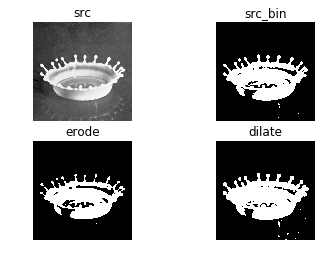

In [4]:
import matplotlib.pyplot as plt

def erode_dilate():
    src = cv2.imread('milkdrop.bmp', cv2.IMREAD_GRAYSCALE)
    
    # ret_T, bin_dst / 0 : 자동으로 결정된 임계값을 구하므로, T 대신 0 지정
    _, src_bin = cv2.threshold(src, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    dst1 = cv2.erode(src_bin, None)
    dst2 = cv2.dilate(src_bin, None)
    
    plt.subplot(221), plt.axis('off'), plt.imshow(src, 'gray'), plt.title('src')
    plt.subplot(222), plt.axis('off'), plt.imshow(src_bin, 'gray'), plt.title('src_bin')
    plt.subplot(223), plt.axis('off'), plt.imshow(dst1, 'gray'), plt.title('erode')
    plt.subplot(224), plt.axis('off'), plt.imshow(dst2, 'gray'), plt.title('dilate')
    plt.show()
    plt.close()
    
erode_dilate()

## 이진 영상의 열기와 닫기
* 열기 : **침식 -> 팽창** (**작은 잡음들이 효과적으로 제거됨**)
* 닫기 : **팽창 -> 침식** (**작은 구멍들이 메워짐**)
> 객체 영역의 크기가 크게 바뀌지 않고, 적용 순서에 따라 서로 다른 효과 발생  
![](morph2.png)
* **cv2.morphologyEx(src, MorphType, kernel)** : 열기와 닫기 연산 수행 (일반적인 모폴로지 연산도 수행)
    * MorphType : MORPH_ERODE, MORPH_DILATE, MORPH_OPEN, MORPH_CLOSE, MORPH_GRADIENT(dilate - erode ==> 객체의 외곽선)

## (실습) 이진 영상의 열기와 닫기

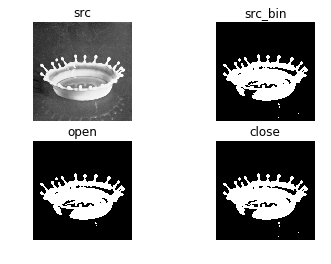

In [5]:
def open_close():
    src = cv2.imread('milkdrop.bmp', cv2.IMREAD_GRAYSCALE)
    
    _, src_bin = cv2.threshold(src, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    dst1 = cv2.morphologyEx(src_bin, cv2.MORPH_OPEN, None)
    dst2 = cv2.morphologyEx(src_bin, cv2.MORPH_CLOSE, None)
    
    plt.subplot(221), plt.axis('off'), plt.imshow(src, 'gray'), plt.title('src')
    plt.subplot(222), plt.axis('off'), plt.imshow(src_bin, 'gray'), plt.title('src_bin')
    plt.subplot(223), plt.axis('off'), plt.imshow(dst1, 'gray'), plt.title('open')
    plt.subplot(224), plt.axis('off'), plt.imshow(dst2, 'gray'), plt.title('close')
    plt.show()
    plt.close()
    
open_close()